In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import kv

# Auxiliar functions for emissivity

In [2]:
class FxParam:
    def __init__(self, xval, alpha):
        self.xval = xval
        self.alpha = alpha

def sync_get_kz(t, fx_p):
    x = fx_p.xval
    alpha = fx_p.alpha
    if alpha < 1.0:
        return np.exp(-x * np.cosh(t)) * np.cosh(alpha * t)
    else:
        return np.exp(-x * np.cosh(t)) * np.cosh(alpha * t) / np.cosh(t)

def gauss_quadrature(func, par, xb, xe, nstep, order):
    if order not in [3, 5]:
        raise ValueError("Order must be either 3 or 5")
    
    weights = {
        3: [
            (-np.sqrt(3.0/5.0), 5.0/9.0),
            (0.0, 8.0/9.0),
            (np.sqrt(3.0/5.0), 5.0/9.0)
        ],
        5: [
            (-1.0/3.0*np.sqrt(5.0 - 2.0*np.sqrt(10.0/7.0)), (322.0 + 13.0*np.sqrt(70.0))/900.0),
            (1.0/3.0*np.sqrt(5.0 - 2.0*np.sqrt(10.0/7.0)), (322.0 + 13.0*np.sqrt(70.0))/900.0),
            (-1.0/3.0*np.sqrt(5.0 + 2.0*np.sqrt(10.0/7.0)), (322.0 - 13.0*np.sqrt(70.0))/900.0),
            (1.0/3.0*np.sqrt(5.0 + 2.0*np.sqrt(10.0/7.0)), (322.0 - 13.0*np.sqrt(70.0))/900.0),
            (0.0, 128.0/225.0)
        ]
    }
    
    dx = (xe - xb) / nstep
    I = 0.0
    for i in range(nstep):
        xb_i, xe_i = xb + i * dx, xb + (i + 1) * dx
        Isub = sum(w * func(0.5 * (xe_i - xb_i) * z + 0.5 * (xe_i + xb_i), par) for z, w in weights[order])
        I += 0.5 * (xe_i - xb_i) * Isub
    
    return I

def sync_generate_fx_and_gx(x):
    fx_p = FxParam(x, 5.0/3.0)
    gx_p = FxParam(x, 2.0/3.0)
    fx_by_x = gauss_quadrature(sync_get_kz, fx_p, 0.0, 32.0, 1600, 5)
    gx_by_x = gauss_quadrature(sync_get_kz, gx_p, 0.0, 32.0, 1600, 5)
    return fx_by_x, gx_by_x

def initial_spectrum(ipart, p, s, norm):
    me = 9.1093820e-28  # Electron mass (g)
    c = 2.9979246e10    # Speed of light (cm/s)
    pp = p / (me * c)
    n0 = norm
    return np.log10(n0 * pp**-s)

In [ ]:
# Just double-check that we have np.log10() in the emiss

In [3]:
def sync_emissivity_trapezoidal(n_grid, freq_ghz, Bfld, np_i, p, kernel_func=None,
                                use_pitch_average=True):
    """
    Synchrotron emissivity with trapezoidal integration over physical momentum p.

    Parameters
    ----------
    n_grid : int
        Number of momentum grid points (len(p) == len(log10Ncre) == n_grid).
    freq_ghz : float
        Observing frequency in GHz.
    Bfld : array-like, shape (3,)
        Magnetic field vector [G] in cgs.
    np_i : array-like
        n(p) with units [cm^-3 / (g cm s^-1)], i.e. dn/dp in cgs.
    p : array-like
        Physical momentum grid [g cm s^-1], not dimensionless.
    kernel_func : callable, optional
        Function kernel_func(x) -> (F_over_x, G_over_x), where F_over_x = F(x)/x etc.
        If None, tries to call `sync_generate_fx_and_gx(x)`.
    use_pitch_average : bool
        If True, use <sin α> = π/4 so B_perp_mag = (π/4)|B| for the magnitude in the integral.
        If False, use |B_perp| = sqrt(Bx^2 + By^2) for the magnitude.

    Returns
    -------
    I, Q, U : floats
        Emissivity per steradian [erg s^-1 cm^-3 Hz^-1 sr^-1] in the sky frame.
    """
    pi = np.pi
    me = 9.10938356e-28    # g
    c  = 2.99792458e10     # cm/s
    qe = 4.80320427e-10    # esu


    if n_grid < 2 or p.size < 2 or not np.isfinite(Bfld).all():
        return 0.0, 0.0, 0.0

    # Frequency
    nu = float(freq_ghz) * 1e9  # Hz

    # B for magnitude inside integral (pitch-angle average) and direction for rotation
    Bx, By, Bz = Bfld
    Bmag = np.linalg.norm(Bfld)

    if use_pitch_average:
        Bperp_mag = (pi / 4.0) * Bmag                 # <sin α> * |B|
    else:
        Bperp_mag = np.sqrt(Bx*Bx + By*By)            # actual |B_perp| magnitude

    # Orientation (LOS = ẑ)
    denom = Bx*Bx + By*By
    if denom > 0.0:
        cos2chi = (By*By - Bx*Bx) / denom
        sin2chi = (-2.0 * Bx * By) / denom
    else:
        cos2chi, sin2chi = 1.0, 0.0

    # Dimensionless momentum, gamma, and kernel argument x = nu / nu_c
    ph = p / (me * c)
    gamma = np.sqrt(1.0 + ph*ph)
    nu_c = (3.0 * qe * Bperp_mag / (4.0 * pi * me * c)) * gamma*gamma  # Hz
    x = nu / nu_c                                                      # dimensionless

    # Get kernel values: F(x)/x, G(x)/x  ->  F(x), G(x)
    if kernel_func is None:
        try:
            F_over_x, G_over_x = sync_generate_fx_and_gx(x)  # we have this in the FP code
        except NameError as e:
            raise NameError("Provide kernel_func=... that returns (F/x, G/x) for array x.") from e
    else:
        F_over_x, G_over_x = kernel_func(x) # just in case another function can be given 

    F = x * F_over_x
    G = x * G_over_x

    # n(p)  (units: cm^-3 / (g cm s^-1))
    n = np_i

    # Trapezoidal rule over segments
    dp = np.diff(p)
    IF = np.sum(0.5 * (n[:-1]*F[:-1] + n[1:]*F[1:]) * dp)  # ∫ n F dp
    IG = np.sum(0.5 * (n[:-1]*G[:-1] + n[1:]*G[1:]) * dp)  # ∫ n G dp

    # Physical prefactor: √3 e^3 / (4π m_e c^2)
    Kpref = np.sqrt(3.0) * qe**3 / (4.0 * pi * me * c**2)

    # Local (basis-aligned) Stokes: I0 from F, Q0 from G (U0=0)
    I0 = Kpref * Bperp_mag * IF
    Q0 = Kpref * Bperp_mag * IG

    # Rotate to sky frame
    I = I0
    Q = Q0 * cos2chi
    U = Q0 * sin2chi

    # NaN/Inf guards
    if not np.isfinite(I): I = 0.0
    if not np.isfinite(Q): Q = 0.0
    if not np.isfinite(U): U = 0.0

    return I, Q, U

# Functions for DSA integral

In [4]:
class GasData:
    """
    Class representing gas properties for a simulation step.
    
    Attributes:
    - Mach (float): Mach number of the gas.
    - Rho (float): Density of the gas (code units).
    - U (float): Internal energy per unit mass (code units).
    - ID (int): Unique identifier for the gas element.
    """

    def __init__(self, Mach, Rho, U, ID):
        self.Mach = Mach  # Mach number
        self.Rho = Rho  # Density in code units
        self.U = U  # Internal energy per mass in code units
        self.ID = ID  # Unique ID of the gas element

    def __repr__(self):
        return f"GasData(Mach={self.Mach}, Rho={self.Rho}, U={self.U}, ID={self.ID})"


In [5]:
def cre_spectral_index(mach):
    if mach <= 1.01:  # Formula diverges, return maximum
        return sys.float_info.max  

    m2 = mach ** 2  # 

    s = 2 * (m2 + 1) / (m2 - 1)

    return s


def injection_efficiency_Kang07(mach):
    coeff = [5.46, -9.78, 4.17, -0.334, 0.570]

    if mach <= 2:
        return 1.96e-3 * (mach ** 2 - 1)  # Eq. A2

    mach4 = (mach ** 2) ** 2  

    eta = sum(coeff[i] * (mach - 1) ** i / mach4 for i in range(5))  # Eq. A5

    return eta


def cre_energy_integral(s, pmin, NSTEP=1000):
    pmax = 1e50  # ~= infinity

    step = np.log10(pmax / pmin) / (NSTEP - 1)

    p_last = pmin
    f_last = (pmin ** -s) * (np.sqrt(pmin ** 2 + 1) - 1)

    integral = 0

    for i in range(1, NSTEP):
        p = pmin * (10 ** (i * step))

        dp = p - p_last

        f = (p ** -s) * (np.sqrt(p ** 2 + 1) - 1)

        integral += 0.5 * dp * (f + f_last)  # Trapezoidal rule

        p_last = p
        f_last = f

    # Output is dimensionless, but if p is in cgs, result is in (m_e c)^(1-s) units
    return integral

def maxwellian(temp, p, nth):
    m_e = 9.10938356e-28  # Electron mass in g
    k_B = 1.380649e-16  # Boltzmann constant in erg/K
    pi = np.pi

    arg = 2 * m_e * k_B * temp

    return nth * 4 * pi * p**2 * (pi * arg) ** -1.5 * np.exp(- (p**2) / arg)  # in cm^-3 * (m_e * c)^-1


def downstream_quantities_temp_jump(SphP_i, mach, Xi_ep):
    """
    Computes downstream quantities for shock analysis.
    
    Parameters:
    - SphP_i: Object containing gas properties (Mach, Rho, U, ID, etc)

    Returns:
    - Temp_dw: Downstream temperature (K)
    - Nth_dw: Downstream number density (1/cm^3)
    - EpsCRe: Cosmic ray energy density (erg/cm^3)
    """

    # Constants
    k_B = 1.380649e-16  # Boltzmann constant in erg/K
    m_p = 1.6726219e-24  # Proton mass in g
    # Derived quantities
    H_frac = 0.76
    He_frac = 1.0 - H_frac
    yHelium = He_frac / (4.0 * H_frac)
    mean_mol_weight = (1.0 + 4.0 * yHelium) / (1.0 + 3.0 * yHelium + 1.0)
    adiabatic_index = 5/3  # Gamma for monatomic ideal gas
    Ktocm2s2 = (3.0 / 2.0 * k_B) / (m_p * mean_mol_weight)
    gamma = adiabatic_index
    
    Unit_Length = 3.08568e+21 #cm
    Unit_Time   = 3.08568e+16 #sec
    Unit_Mass   = 1.989e+43   #g
    Unit_Vel     = Unit_Length/Unit_Time
    Unit_Density = Unit_Mass /(Unit_Length)**3
    
    #Xi_ep = 1e-6        # -> input parameter now 

    # Downstream (post-shock) properties
    rho_dw = SphP_i.Rho
    t_dw = temperature_cgs(SphP_i.U)  # in K

    Nth_dw = number_density_cgs(rho_dw)  # in 1/cm^3
    Temp_dw = t_dw

    u_dw = SphP_i.U

    epsTherm_dw = thermal_energy_density_cgs(u_dw, rho_dw)  # in erg/cm^3

    mach2 = mach ** 2  # Mo, v.d.Bosch & White, eq. 8.49

    sigma = 1 / (1/mach2 + (gamma - 1) / (gamma + 1) * (1 - 1/mach2))  # rho_dw/rho_up = sigma

    # Upstream (pre-shock) properties
    rho_up = rho_dw / sigma

    t_up = t_dw * ((gamma + 1) ** 2 * mach2) / ((2 * gamma * mach2 - (gamma - 1)) * ((gamma - 1) * mach2 + 2))  # in K

    u_up = t_up * Ktocm2s2 / (Unit_Vel ** 2)  # Convert T [K] to energy per mass unit [cm^2/s^2], code units

    epsTherm_up = thermal_energy_density_cgs(u_up, rho_up)  # in erg/cm^3

    eta_cre = Xi_ep * injection_efficiency_Kang07(mach)

    # Cosmic ray energy density
    EpsCRe = eta_cre * (epsTherm_dw - epsTherm_up * sigma ** gamma)  # in erg/cm^3, Ensslin+ 2007

    # Handle invalid values
    if EpsCRe < 0 or not np.isfinite(EpsCRe):
        EpsCRe = 0

    return Temp_dw, Nth_dw, EpsCRe

def cre_spectrum_normalisation(SphP_i, s, mach, Xi_ep):
    """
    Computes the normalization factor for the cosmic ray electron (CRe) spectrum.

    Parameters:
    - SphP_i: Object containing gas properties (Mach, Rho, U, ID)
    - s: Spectral index
    - Unit: Object with velocity units
    - Param: Object containing parameters like Xi_ep

    Returns:
    - cre_norm: Normalization of the CRe spectrum
    """
    
    BISECTION_ACCURACY = 1e-6  # Define a suitable accuracy for the bisection method
    c = 2.99792458e10  # Speed of light in cm/s
    m_e = 9.10938356e-28  # Electron mass in g
    k_B = 1.380649e-16  # Boltzmann constant in erg/K

    # Compute downstream quantities (this is all in CGS)
    temp_dw, nth_dw, epsCRe = downstream_quantities_temp_jump(SphP_i, mach, Xi_ep)

    if epsCRe == 0:
        return 0

    # Normalization factor
    cre_norm_fac = epsCRe / (c * (m_e * c) ** (2 - s))

    # Maxwellian peak
    left = np.sqrt(2 * m_e * k_B * temp_dw)  # Peak of Maxwellian
    right = left * 30  # Upper limit, Maxwellian is steep

    delta = 1
    p_inj = 0
    it = 0

    # Root finding via bisection method
    while abs(delta) > BISECTION_ACCURACY:
        p_inj = left + 0.5 * (right - left)

        n_maxw = maxwellian(temp_dw, p_inj, nth_dw)  # in cm^-3 * (m_e * c)^-1
        cre_norm = cre_norm_fac / cre_energy_integral(s, p_inj / (m_e * c))  # in cm^-3 * (m_e * c)^(s-1)
        n_cre = cre_spectrum(cre_norm, p_inj, s)  # in cm^-3 * (m_e * c)^-1

        delta = (n_maxw - n_cre) / (n_maxw + n_cre)  # Weighted difference


        it += 1

        if delta > 0:
            left = p_inj
        else:
            right = p_inj

    return cre_norm

def cre_spectrum(norm, p, s):
    """
    Computes the cosmic ray electron (CRe) spectrum.

    Parameters:
    - norm: Normalization factor
    - p: Momentum
    - s: Spectral index

    Returns:
    - CRe spectrum value
    """
    return norm * p ** -s

def thermal_energy_density_cgs(u, rho):
    """
    Computes the thermal energy density in CGS units (erg/cm^3).

    Parameters:
    - u: Internal energy per unit mass (code units, cm^2/s^2)
    - rho: Density (code units)

    Returns:
    - Thermal energy density in erg/cm^3
    """
    # Physical constants
    k_B = 1.380649e-16  # Boltzmann constant in erg/K
    m_p = 1.6726219e-24  # Proton mass in g
    
    # Derived quantities
    H_frac = 0.76
    He_frac = 1.0 - H_frac
    u_mol = 4.0 / (5.0 * H_frac + 3.0)  # Updated from the provided definition

    return 1.5 * density_cgs(rho) / (m_p * u_mol) * k_B * temperature_cgs(u)  # Output in erg/cm^3

def temperature_cgs(u):
    """
    Computes the temperature in CGS units (Kelvin).

    Parameters:
    - u: Internal energy per unit mass (cm^2/s^2)
    - Unit: Object containing velocity units (Unit.Vel in cm/s)

    Returns:
    - Temperature in Kelvin (K)
    """
    # Physical constants
    k_B = 1.380649e-16  # Boltzmann constant in erg/K
    m_p = 1.6726219e-24  # Proton mass in g
    
    Unit_Length = 3.08568e+21 #cm
    Unit_Time   = 3.08568e+16 #sec
    Unit_Mass   = 1.989e+43   #g
    Unit_Vel     = Unit_Length/Unit_Time
    Unit_Density = Unit_Mass /(Unit_Length)**3

    # Derived quantities
    H_frac = 0.76
    He_frac = 1.0 - H_frac
    yHelium = He_frac / (4.0 * H_frac)
    mean_mol_weight = (1.0 + 4.0 * yHelium) / (1.0 + 3.0 * yHelium + 1.0)

    return (2.0 / 3.0) * u * (Unit_Vel ** 2) * m_p * mean_mol_weight / k_B  # Output in K

def density_cgs(rho):
    """
    Converts density from code units to CGS (g/cm^3).

    Parameters:
    - rho: Density in code units
    - Unit: Object containing unit conversions (Mass, Length)
    - Cosmo: Object containing cosmological parameters (h)

    Returns:
    - Density in g/cm^3
    """
    
    Unit_Length = 3.08568e+21 #cm
    Unit_Time   = 3.08568e+16 #sec
    Unit_Mass   = 1.989e+43   #g
    Unit_Vel     = Unit_Length/Unit_Time
    Unit_Density = Unit_Mass /(Unit_Length)**3
    
    h = 0.7
    
    return (rho * Unit_Mass / (Unit_Length ** 3)) * (h ** 2)


def number_density_cgs(rho):
    """
    Computes the number density in CGS units (1/cm^3).

    Parameters:
    - rho: Density in code units
    - Unit: Object containing unit conversions
    - Cosmo: Object containing cosmological parameters

    Returns:
    - Number density in cm^-3
    """
    # Physical constants
    m_p = 1.6726219e-24  # Proton mass in g
    H_frac = 0.76
    He_frac = 1.0 - H_frac
    u_mol = 4.0 / (5.0 * H_frac + 3.0)
    n2ne = (H_frac + 0.5 * He_frac) / (2.0 * H_frac + 0.75 * He_frac)

    return density_cgs(rho) * n2ne / (u_mol * m_p)

def compute_Q(Q, CRe_norm, p_cgs, s, dt):
    """
    Computes the spectrum for all grid points.

    Parameters:
    - Q: Output array to store results
    - CRe_norm: Normalization factor
    - p_cgs: Array of momenta in CGS units
    - s: Spectral index
    - dt: Time step

    Modifies Q in place.
    """
    Q[:] = cre_spectrum(CRe_norm, p_cgs, s) / dt  

# Momentum grid

In [6]:
# Momentum grid
me = 9.1093820e-28  # Electron mass (g)
c = 2.9979246e10    # Speed of light (cm/s)
Pmin   = (me*c)*100
Pmax   = (me*c)*1e6
n_grid = 128
pstep  = np.log10(Pmax / Pmin) / (n_grid - 1)
p      = np.array([Pmin * 10**(i * pstep) for i in range(n_grid)])

# Distribution function according to DSA

Mach:  2.58 , s_M:  4.707163566933032 , 2-s_M:  -2.7071635669330316
n(p) index:  2.7071635669330316
alpha.    :  0.8535817834665158
alpha_int :  1.3535817834665158
Spectral index:  2.7071635669330316
Value normalization:  3.301229820291284e-39


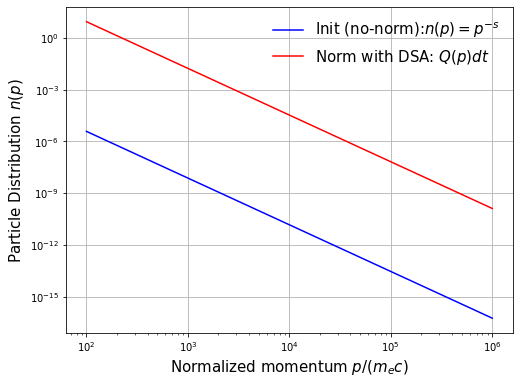

In [7]:
Unit_Length = 3.08568e+21 #cm
Unit_Time   = 3.08568e+16 #sec
Unit_Mass   = 1.989e+43   #g
Unit_Vel     = Unit_Length/Unit_Time
Unit_Density = Unit_Mass /(Unit_Length)**3

# ---------- SELECT A MACH NUMBER
mach = 2.58                        # Example like the Sausage relic
s_M  = 4*(mach**2)/(mach**2-1)     # index of f(p) = p^-s
s_code = 2*(mach**2+1)/(mach**2-1) # index of n(p) = f*4pi p^2
print("Mach: ", mach, ", s_M: ", s_M, ", 2-s_M: ", 2-s_M)
alpha_sync = (s_code - 1)/2
alpha_int  = alpha_sync + 0.5
print("n(p) index: ", s_code)
print("alpha.    : ", alpha_sync)
print("alpha_int : ", alpha_int)
# -----------

mach_test  = mach 
Xi_ep_test = 0.01 #1e-6
u_code_units = 2.104872e5
# Creating an instance of GasData
SphP_i = GasData(Mach=mach_test, Rho=5.81366e-28/Unit_Density, U=u_code_units, ID=12345)

s = cre_spectral_index(mach_test)
print("Spectral index: ", s)

CRe_norm = cre_spectrum_normalisation(SphP_i, s, mach_test, Xi_ep_test)
print("Value normalization: ", CRe_norm)


dt = 2.16269e13       # example dt (this is relevant in the FP code but not here)
n_grid = 128
Q = np.zeros(n_grid)  # Initialize output array

np_i = np.array([10**initial_spectrum(0, p[i], s_code, 1) for i in range(n_grid)]) # p^-s


compute_Q(Q, CRe_norm, p, s, dt) # This gives Q(t) which has units of [n(p)/dt]
np_i_DSA = Q*dt # this is n_0*p^-s
#print(Q)

# Plot momentum vs np_i
plt.figure(figsize=(8, 6))
plt.plot(p / (me * c), np_i, label=f'Init (no-norm):$n(p) = p^{{-s}}$', color='b')
plt.plot(p / (me * c), np_i_DSA, label=f'Norm with DSA: $Q(p) dt$', color='red')
plt.xlabel(r'Normalized momentum $p/(m_e c)$', fontsize=15)
plt.ylabel(r'Particle Distribution $n(p)$', fontsize=15)
plt.legend(frameon=False, fontsize=15)
plt.grid(True)
#plt.loglog(True)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Visualizing the normalization and CR energy due to the shock as a function of the Mach number

Selecting an internal energy corresponding to T= 10000000.153087426  Kelvin


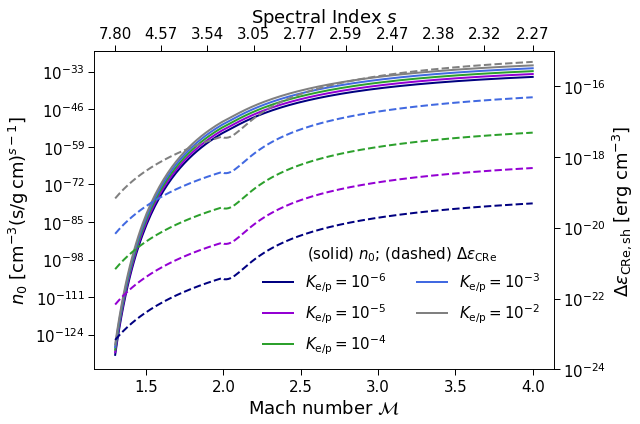

In [8]:
# --- setup ---
mach_test_i = np.linspace(1.3, 4.0, 200)


u_code_units = 2.104872e5
print("Selecting an internal energy corresponding to T=",temperature_cgs(u_code_units), " Kelvin")

# Creating an instance of GasData (use mach_test_i as an example)
SphP_i = GasData(Mach=mach_test_i, Rho=5.81366e-28/Unit_Density, U=u_code_units, ID=12345)

# Xi_ep sweep from 1e-6 to 1e-2 (both included)
Xi_ep_vals = np.logspace(-6, -2, 5)  # 

# Compute s(M) once 
s_i = np.array([cre_spectral_index(m) for m in mach_test_i])

# Storage per Xi_ep
norm_grid = []   
ecre_grid = []  

for Xi_ep in Xi_ep_vals:
    norm_i = []
    e_CRe = []
    for m in mach_test_i:
        s = cre_spectral_index(m)
        norm_ = cre_spectrum_normalisation(SphP_i, s, m, Xi_ep)
        norm_i.append(norm_)
        # downstream quantities (CGS)
        temp_dw_, nth_dw_, epsCRe_ = downstream_quantities_temp_jump(SphP_i, m, Xi_ep)
        e_CRe.append(epsCRe_)
    norm_grid.append(np.asarray(norm_i))
    ecre_grid.append(np.asarray(e_CRe))

norm_grid = np.asarray(norm_grid)
ecre_grid = np.asarray(ecre_grid)
# -----------------


colors = ['navy', 'darkviolet', 'tab:green', 'royalblue', 'gray']

fig, ax1 = plt.subplots(figsize=(9, 6))
ax1.tick_params(axis='both', which='both', labelsize=15, width=1, length=6)

# Left y-axis: normalisation vs Mach, colored by Xi_ep
for Xi_ep, y, c in zip(Xi_ep_vals, norm_grid, colors):
    exp = int(round(np.log10(Xi_ep)))
    #ax1.plot(mach_test_i, y, lw=2, label=fr'$K_{{\rm e/p}}=10^{exp}$') #Xi_ep:.0e
    ax1.plot(
        mach_test_i, y, lw=2,
        label=fr'$K_{{\rm e/p}} = 10^{{{exp}}}$', c=c
    )

ax1.set_xlabel(r'Mach number $\mathcal{M}$', fontsize=18)
ax1.set_ylabel(r'$n_0$ [$\mathrm{cm}^{-3} (\mathrm{s}/\mathrm{g}\, \mathrm{cm})^{s -1}$]', fontsize=18)
#ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.grid(True, which="both", linestyle="--", alpha=0.35)

# Right y-axis: epsCRe vs Mach (same colors, dashed)

ax3 = ax1.twinx()
ax3.tick_params(axis='both', which='both', labelsize=15, width=1, length=6)
for (Xi_ep, y_norm), y_e, c in zip(zip(Xi_ep_vals, norm_grid), ecre_grid, colors):
    ax3.plot(mach_test_i, y_e, lw=2, ls='--', c=c)  # uses same color cycle automatically

ax3.set_ylabel(r'$\Delta \varepsilon_{\rm CRe, sh}$ [erg cm$^{-3}$]', fontsize=18)
ax3.set_yscale('log')
ax3.set_ylim(1e-24, 1e-15)

# Secondary x-axis on top showing s(M)
ax2 = ax1.secondary_xaxis('top')
ax2.tick_params(axis='both', which='both', labelsize=15, width=1, length=6)
# choose a sparse subset to avoid crowding (every ~20th point)
tick_idx = np.linspace(0, len(mach_test_i)-1, 10, dtype=int)
ax2.set_xticks(mach_test_i[tick_idx])
ax2.set_xticklabels([f'{val:.2f}' for val in s_i[tick_idx]])
ax2.set_xlabel(r'Spectral Index $s$', fontsize=18)

# Legend (left axis entries are enough; mention dashed = epsCRe)
leg = ax1.legend(frameon=False, fontsize=15, 
                 title=r'(solid) $n_0$; (dashed) $\Delta \varepsilon_{\rm CRe}$',
                 title_fontsize=15,
                ncol=2)
plt.tight_layout()


plt.show()

# NOTE!!: K_e/p is technically K_e/p*eta_e, where eta_e is the prefactor in the shock acceleration efficiency

# Should we fix that?


# Computing emissivity (I, Q , U)

In [9]:
freqs = [0.05, 0.14, 0.4, 1.4, 3]
Bfld  = np.array([1e-6, 0, 0])  # Magnetic field in Gauss
emiss_np = []
emiss_Qdt = []

# Compute synchrotron emissivity
for freq in freqs:
    
    I_Qdt, Q_Qdt, U_Qdt = sync_emissivity_trapezoidal(n_grid, freq, Bfld, np_i_DSA, p)
    print(f"Qdt: Synchrotron Emissivity at {freq} GHz: {I_Qdt:.3e} erg cm$^{-3}$ s$^{-1}$ Hz$^{-1}$ sr$^{-1}$")
    emiss_Qdt = np.append(emiss_Qdt, I_Qdt)

Qdt: Synchrotron Emissivity at 0.05 GHz: 5.683e-46 erg cm$^-3$ s$^-1$ Hz$^-1$ sr$^-1$
Qdt: Synchrotron Emissivity at 0.14 GHz: 2.360e-46 erg cm$^-3$ s$^-1$ Hz$^-1$ sr$^-1$
Qdt: Synchrotron Emissivity at 0.4 GHz: 9.632e-47 erg cm$^-3$ s$^-1$ Hz$^-1$ sr$^-1$
Qdt: Synchrotron Emissivity at 1.4 GHz: 3.306e-47 erg cm$^-3$ s$^-1$ Hz$^-1$ sr$^-1$
Qdt: Synchrotron Emissivity at 3 GHz: 1.724e-47 erg cm$^-3$ s$^-1$ Hz$^-1$ sr$^-1$


# Check 1. Deriving Mach number from the slope of radio flux vs freq.

No handles with labels found to put in legend.


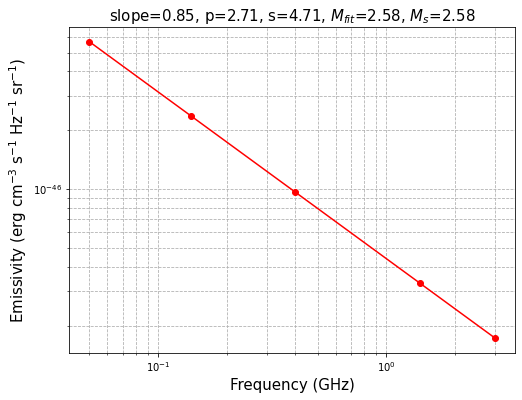

In [12]:
# linear fit in log space
log_freqs = np.log10(freqs)
log_flux = np.log10(emiss_Qdt)
fit_coeffs = np.polyfit(log_freqs, log_flux, 1)  # polyfit degree=1 gives slope & intercept
slope = (-1)*fit_coeffs[0]  # This is the spectral index 
if slope > 0.5:
    mach_fit = np.sqrt((3 + 2 * slope) / (2 * slope - 1))
else:
    mach_fit = np.nan  # Invalid fit if slope < 0.5
    
slope_p = 2*slope +1  # this is the slope of n(p)=f*4pi*p2
slope_q = slope_p + 2 # this is the slope of f(p)

label=f'slope={slope:.2f}, p={slope_p:.2f}, s={slope_q:.2f}, $M_{{fit}}$={mach_fit:.2f}, $M_{{s}}$={mach:.2f}'

# Plot flux vs frequency
plt.figure(figsize=(8, 6))
plt.loglog(freqs, emiss_Qdt, marker='o', linestyle='-', color='r')#, label=label)
plt.xlabel('Frequency (GHz)', fontsize=15)
plt.ylabel(r'Emissivity (erg cm$^{-3}$ s$^{-1}$ Hz$^{-1}$ sr$^{-1}$)', fontsize=15)
plt.title(label, fontsize=15)
plt.legend(frameon=False, fontsize=16)
plt.grid(True, which='both', linestyle='--')

plt.show()

# M_fir = M_s

# Check 2. Polarization fraction from slope

In [14]:
s_est = slope_p
Pi_theory = (s_est + 1) / (s_est + 7/3)
print(f"Π_theory = {Pi_theory:.3f}")

Pol = np.hypot(Q_Qdt, U_Qdt)
pol_frac = Pol / I_Qdt 
chi = 0.5 * np.arctan2(U_Qdt, Q_Qdt)  # radians

print("Polarization fraction: ", pol_frac)
print("Polarization angle: ", np.rad2deg(chi)) # 90 deg expected if we only have a Bx component
    
# pol_frac_theory = pol_frac with I Q and U

Π_theory = 0.735
Polarization fraction:  0.7355378858624618
Polarization angle:  -90.0


# From emissivity to radio flux and power

In [17]:
# ----- geometry -----
# Choose a volume
Mpc_to_cm = 3.086e24
kpc_to_cm = 3.086e21
# Sausage relic: 2 Mpc long, width 100 kpc
V     = (2*Mpc_to_cm)*(100*kpc_to_cm)*(1*Mpc_to_cm)  # cm^3

# Luminosity Distance D_L (typical values for the Sausage relic)
DL_Mpc = 944.0
DL_cm  = DL_Mpc * Mpc_to_cm

# Redshift information for K-correction
z = 0.192
alpha = (slope_p-1)/2
print(slope_p, alpha, alpha-1)
K_factor = (1+z)**(alpha-1) # note that here alpha >0 and it comes from S_nu \proto \nu^{-alpha}

# --- Beam information ---
# Beam FWHM in arcsec
theta_maj_arcsec = 10 # -> change accordingly to an observation
theta_min_arcsec = 10

# Convert to radians
arcsec_to_rad = np.pi / (180.0 * 3600.0)
theta_maj = theta_maj_arcsec * arcsec_to_rad
theta_min = theta_min_arcsec * arcsec_to_rad

# Beam solid angle [sr]
Omega_beam = (np.pi / (4 * np.log(2))) * theta_maj * theta_min

# Integrated along a distance L
L = 2*Mpc_to_cm

# Flux density and power
print(" -- Flux (Jy) --")
for j in range(0,5):
    S_nu_cgs = (emiss_Qdt[j] * V) / (DL_cm**2)    # erg s^-1 cm^-2 Hz^-1
    S_nu_Jy  = S_nu_cgs * 1e23                    # Jy

    print(f"S_{{{freqs[j]:.2f} GHz}} ≈ {S_nu_Jy:.3e} Jy")
    
print(" -- Power --")
for j in range(0,5):
    L_nu_cgs = 4 * np.pi * emiss_Qdt[j] * V   # erg/s/Hz (or 4pi S_nu * D_L^2)
    P_nu_WHz = L_nu_cgs * 1e-7                # W/Hz
    P_nu_WHz_Kcorrected = P_nu_WHz * K_factor # including K-correction
    
    print(f"P_{{{freqs[j]:.2f} GHz}} ≈ {P_nu_WHz:.3e} W Hz^-1, {P_nu_WHz_Kcorrected:.3e} W Hz^-1 (K-corrected)")
    
print(" -- Flux (Jy/beam)--")
for j in range(0,5):
    I_nu_cgs = (emiss_Qdt[j] * L)        # erg s^-1 cm^-2 Hz^-1 sr^-1
    I_nu_Jy  = I_nu_cgs * 1e23           # Jy
    I_nu_per_beam = I_nu_Jy * Omega_beam # Jy/beam

    print(f"S_{{{freqs[j]:.2f} GHz}} ≈ {I_nu_per_beam:.3e} Jy/beam")
    

2.7072811108160497 0.8536405554080249 -0.14635944459197514
 -- Flux (Jy) --
S_{0.05 GHz} ≈ 3.936e-05 Jy
S_{0.14 GHz} ≈ 1.634e-05 Jy
S_{0.40 GHz} ≈ 6.671e-06 Jy
S_{1.40 GHz} ≈ 2.289e-06 Jy
S_{3.00 GHz} ≈ 1.194e-06 Jy
 -- Power --
P_{0.05 GHz} ≈ 4.198e+21 W Hz^-1, 4.091e+21 W Hz^-1 (K-corrected)
P_{0.14 GHz} ≈ 1.743e+21 W Hz^-1, 1.699e+21 W Hz^-1 (K-corrected)
P_{0.40 GHz} ≈ 7.114e+20 W Hz^-1, 6.934e+20 W Hz^-1 (K-corrected)
P_{1.40 GHz} ≈ 2.442e+20 W Hz^-1, 2.380e+20 W Hz^-1 (K-corrected)
P_{3.00 GHz} ≈ 1.274e+20 W Hz^-1, 1.241e+20 W Hz^-1 (K-corrected)
 -- Flux (Jy/beam)--
S_{0.05 GHz} ≈ 9.341e-07 Jy/beam
S_{0.14 GHz} ≈ 3.879e-07 Jy/beam
S_{0.40 GHz} ≈ 1.583e-07 Jy/beam
S_{1.40 GHz} ≈ 5.434e-08 Jy/beam
S_{3.00 GHz} ≈ 2.835e-08 Jy/beam
